# COVID data -Visualization with PCA, Similarity Measurement with Cosine Similarity
#Background

We will use Principal Component Analysis (PCA) and Cosine Similarity to see if we can detect similarities between each country's COVID data such as number of new cases, number of new deaths etc. 


# Data
https://github.com/owid/covid-19-data/tree/master/public/data Accessed: 08/21/2020.


In [ ]:
#import libraries we may need
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import Normalizer
import pickle
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!gdown --id 1reHd99dP3ZjE4gNa7IhPxOywt0B-IjtI --output covid_data.csv


Downloading...
From: https://drive.google.com/uc?id=1reHd99dP3ZjE4gNa7IhPxOywt0B-IjtI
To: /content/covid_data.csv
8.23MB [00:00, 72.9MB/s]


In [ ]:
covid_df = pd.read_csv('covid_data.csv')

# Exploratory Data Analysis
Let's take a quick look at few of the data aspects

In [ ]:
covid_df.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
count,3.848400e+04,38311.000000,37530.000000,38484.000000,38311.000000,37530.000000,38247.000000,38247.000000,37465.000000,38247.000000,38247.000000,37465.000000,12362.000000,1.268600e+04,12686.000000,12362.000000,13867.000000,13867.000000,12781.000000,13138.000000,32103.000000,3.882300e+04,37101.000000,34902.000000,34391.000000,34722.000000,34473.000000,23023.000000,34915.000000,36127.000000,27542.000000,27201.000000,16169.000000,31654.000000,38346.000000
mean,6.985696e+04,1213.417609,1196.172990,3223.473314,42.063115,41.977073,1402.081429,20.682948,20.280112,47.709329,0.543831,0.543529,19326.363938,1.055368e+06,40.655005,0.642739,18347.087690,0.613001,200.995509,0.063111,58.114253,9.138571e+07,366.938077,31.480766,9.353315,5.922415,21229.420215,11.758402,250.619175,8.044788,10.894679,32.639686,52.931976,3.130104,74.139786
std,7.221771e+05,11195.152877,10952.517772,30321.530959,360.869322,350.012834,3184.657395,66.727446,50.628925,131.280836,2.914640,1.939981,71843.409824,4.279781e+06,74.392427,1.153490,65451.776213,1.026464,1026.662072,0.090957,28.528832,6.245423e+08,1684.105164,9.015101,6.345241,4.337492,20584.288645,18.946352,117.880027,4.129592,10.491138,13.381893,31.508574,2.542240,7.342640
min,0.000000e+00,-2461.000000,-338.857000,0.000000,-1918.000000,-232.143000,0.000000,-265.189000,-19.206000,0.000000,-41.023000,-4.965000,-3743.000000,1.000000e+00,0.000000,-0.398000,0.000000,0.000000,1.535000,0.000000,0.000000,8.090000e+02,0.137000,15.100000,1.144000,0.526000,661.240000,0.100000,79.370000,0.990000,0.100000,7.700000,1.188000,0.100000,53.280000
25%,3.000000e+01,0.000000,0.429000,0.000000,0.000000,0.000000,15.828500,0.000000,0.076000,0.000000,0.000000,0.000000,946.000000,3.774750e+04,2.260250,0.061000,1038.500000,0.063000,12.049000,0.007000,38.890000,1.402985e+06,39.497000,24.300000,3.556000,2.155000,5591.597000,0.500000,153.507000,5.310000,1.900000,21.400000,22.863000,1.380000,70.260000
50%,6.960000e+02,7.000000,11.286000,11.000000,0.000000,0.143000,214.181000,1.105000,2.334000,3.275000,0.000000,0.013000,3215.000000,1.560995e+05,12.054000,0.271500,3535.000000,0.289000,35.188000,0.027000,65.740000,8.655541e+06,90.672000,31.400000,6.991000,4.455000,14600.861000,1.800000,237.372000,7.110000,6.434000,31.400000,55.182000,2.500000,75.800000
75%,7.387250e+03,130.000000,133.857000,150.000000,2.000000,2.571000,1305.792500,13.354500,14.829000,28.099000,0.175000,0.248000,11110.750000,5.838978e+05,48.480750,0.767000,11575.500000,0.757000,121.998000,0.080750,80.560000,3.125544e+07,222.873000,39.700000,14.799000,9.719000,32605.906000,15.000000,318.949000,10.180000,19.600000,40.900000,83.741000,4.210000,80.035000
max,2.324362e+07,298094.000000,263460.857000,805740.000000,10542.000000,7464.000000,40528.486000,4944.376000,882.924000,1237.551000,200.040000,63.140000,926876.000000,6.958068e+07,745.977000,22.359000,830795.000000,15.820000,47299.000000,0.651000,100.000000,7.794799e+09,19347.500000,48.200000,27.049000,18.493000,116935.600000,77.600000,724.417000,23.360000,44.000000,78.100000,98.999000,13.800000,86.750000


In [ ]:
covid_df.dtypes

iso_code                            object
continent                           object
location                            object
date                                object
total_cases                        float64
new_cases                          float64
new_cases_smoothed                 float64
total_deaths                       float64
new_deaths                         float64
new_deaths_smoothed                float64
total_cases_per_million            float64
new_cases_per_million              float64
new_cases_smoothed_per_million     float64
total_deaths_per_million           float64
new_deaths_per_million             float64
new_deaths_smoothed_per_million    float64
new_tests                          float64
total_tests                        float64
total_tests_per_thousand           float64
new_tests_per_thousand             float64
new_tests_smoothed                 float64
new_tests_smoothed_per_thousand    float64
tests_per_case                     float64
positive_ra

In [ ]:
covid_df[covid_df['location'] == 'United States'].tail(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
36971,USA,North America,United States,2020-08-19,5482416.0,44091.0,48744.143,171821.0,1324.0,1040.571,16563.058,133.204,147.262,519.093,4.000,3.144,680934.0,68944867.0,208.291,2.057,744795.0,2.250,15.280,0.065,units unclear (incl. non-PCR),NaN,331002647.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86
36972,USA,North America,United States,2020-08-20,5529842.0,47426.0,47527.714,173177.0,1356.0,1021.429,16706.338,143.280,143.587,523.189,4.097,3.086,635809.0,69580676.0,210.212,1.921,709806.0,2.144,14.935,0.067,units unclear (incl. non-PCR),NaN,331002647.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86
36973,USA,North America,United States,2020-08-21,5573847.0,44005.0,46515.000,174255.0,1078.0,1020.714,16839.282,132.945,140.528,526.446,3.257,3.084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,331002647.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86
36974,USA,North America,United States,2020-08-22,5623727.0,49880.0,44378.143,175406.0,1151.0,994.286,16989.976,150.694,134.072,529.923,3.477,3.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,331002647.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86
36975,USA,North America,United States,2020-08-23,5668105.0,44378.0,43848.571,176362.0,956.0,983.000,17124.047,134.071,132.472,532.811,2.888,2.970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,331002647.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86


In [ ]:
#check for NULLs
percent_missing = covid_df.isnull().sum() * 100 / len(covid_df)
perc_nulls_df = pd.DataFrame({'column_name': covid_df.columns, 'percent_missing': percent_missing})
#look at only the columns with less than 10% missing values
display(perc_nulls_df[perc_nulls_df['percent_missing'] < 10])

,column_name,percent_missing
iso_code,iso_code,0.606759
continent,continent,1.213518
location,location,0.000000
date,date,0.000000
total_cases,total_cases,1.474654
new_cases,new_cases,1.917563
new_cases_smoothed,new_cases_smoothed,3.917051
total_deaths,total_deaths,1.474654
new_deaths,new_deaths,1.917563
new_deaths_smoothed,new_deaths_smoothed,3.917051


In [ ]:
descriptive_columns = ['location', 'date']
feature_columns = ['total_cases_per_million',
            'new_cases_per_million', 
            'total_deaths_per_million', 
            'new_deaths_per_million' 
            #'population_density',
            #'life_expectancy'
            ]

columns_of_interest = descriptive_columns + feature_columns

#Create behavior vectors for each country


In [ ]:
target_df = covid_df[columns_of_interest].copy()
#drop all rows that have any null values
target_df.dropna(inplace=True)

In [ ]:
#scale the data
X_train = target_df[feature_columns].to_numpy().tolist()
scaler = StandardScaler()
transformer = scaler.fit(X_train)
X_train_scaled = transformer.transform(X_train)

In [ ]:
target_df['metrics_vector'] = X_train_scaled.tolist()

In [ ]:
target_df.tail(5)

,location,date,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,metrics_vector
38818,World,2020-08-19,2842.863,32.702,100.229,0.857,"[0.4524192801133384, 0.1801239222867414, 0.400..."
38819,World,2020-08-20,2878.909,36.046,101.068,0.839,"[0.4637380710419927, 0.23023888887237273, 0.40..."
38820,World,2020-08-21,2914.030,35.120,101.881,0.813,"[0.47476640306788376, 0.21636135924967695, 0.4..."
38821,World,2020-08-22,2947.860,33.830,102.661,0.781,"[0.4853893486684046, 0.19702873158955006, 0.41..."
38822,World,2020-08-23,2981.940,34.080,103.369,0.708,"[0.49609079667507766, 0.2007753648570165, 0.42..."


In [ ]:
#take the most recent date
max_date = target_df.date.max()
target_most_recent_df = target_df[target_df['date'] == max_date]

In [ ]:
#take a small sample 
state = np.random.RandomState(13)
sample_df = target_most_recent_df.sample(n = 10, random_state=state)

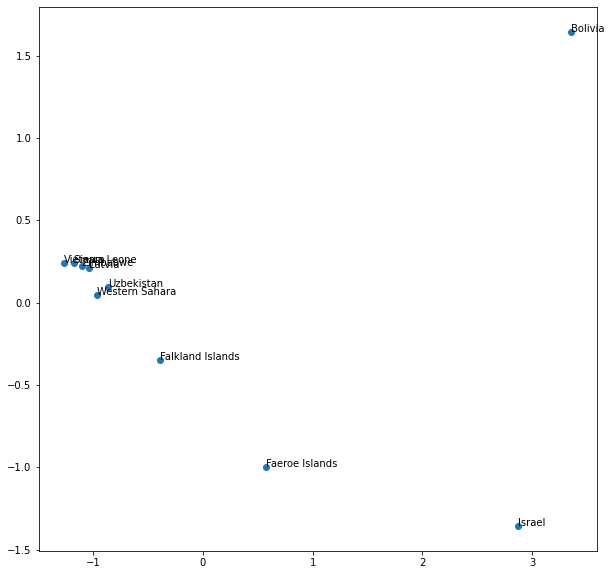

In [ ]:
X = np.stack(np.array(sample_df['metrics_vector']))
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(1, figsize = (10, 10))
plt.scatter(result[:, 0], result[:, 1])
words = list(sample_df['location'])
for i, word in enumerate(words):
  plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [ ]:
sample_df [sample_df['location'].isin (['Bolivia', 'Uzbekistan', 'Zimbabwe', 'Western Sahara', 'Israel'])]



,location,date,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,metrics_vector
38585,Zimbabwe,2020-08-23,396.490,5.248,10.294,0.067,"[-0.3157653872701373, -0.23131635661335478, -0..."
37451,Uzbekistan,2020-08-23,1156.227,13.953,8.037,0.209,"[-0.07720065709860598, -0.10085858624017281, -..."
38135,Western Sahara,2020-08-23,1282.373,0.000,1.674,0.000,"[-0.03758959899268507, -0.3099656821640106, -0..."
17872,Israel,2020-08-23,11793.601,157.587,94.621,1.155,"[3.2630371594664203, 2.0517171047169342, 0.357..."
4577,Bolivia,2020-08-23,9288.677,84.982,380.535,6.511,"[2.4764669145524656, 0.9636198711793266, 2.535..."


As hoped, we seem to be getting similar data points closer together on the graph.

Let's visualize in 3D space.

In [ ]:
X = np.stack(np.array(sample_df['metrics_vector']))
pca = PCA(n_components=3)
result = pca.fit_transform(X)

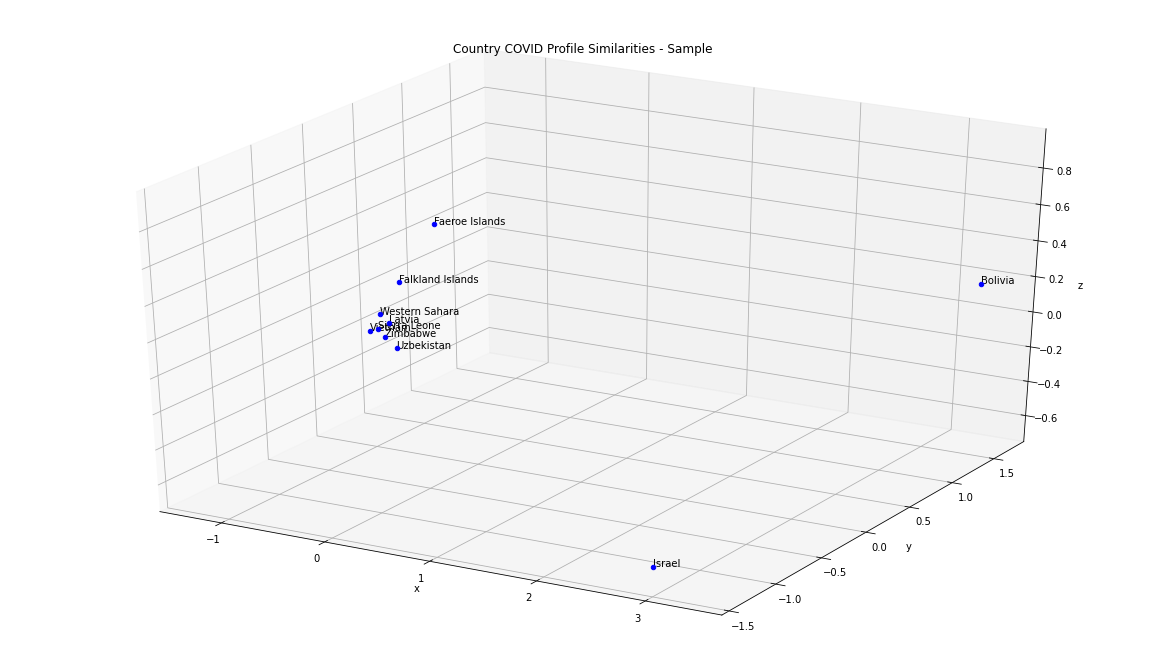

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand

m=rand(3,3) # m is an array of (x,y,z) coordinate triplets
m=result

fig = plt.figure(figsize = (16, 9))
ax = Axes3D(fig)
words = list(sample_df['location'])

for i in range(len(m)): #plot each point + it's index as text above
 ax.scatter(m[i,0],m[i,1],m[i,2], color='b') 
 ax.text(m[i,0],m[i,1],m[i,2],  '%s' % (words[i]), size=10, zorder=1,  
 color='k') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Country COVID Profile Similarities - Sample')
plt.show()

# Cosine Similarity
We will now use Cosine Similarity to calculate distance (i.e. similarity) between the countries' COVID metrics vectors

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similarity(country, data_df):
  result_lst = []
  target_country_vector = data_df['metrics_vector'].values[data_df['location'] == country]
  target_country_vector = np.array(target_country_vector[0]).reshape(1,-1)
  #remove target country from search
  data_df = data_df[data_df['location'] != country]
  for record in data_df[['location', 'metrics_vector']].values:
    #cosine_sim = cosine_similarity(np.array(target_country_vector), np.array(record[1]))

    cosine_sim = cosine_similarity(target_country_vector, np.array(record[1]).reshape(1,-1))
    my_tuple = (record[0], cosine_sim)
    result_lst.append(my_tuple)
    #print (my_tuple)
  result_lst.sort(key=lambda tup: tup[1], reverse=True)
  print (result_lst)

In [ ]:
#let's find which countries are most similar to Germany
find_similarity('Germany', target_most_recent_df)

[('Guernsey', array([[0.981853]])), ('Denmark', array([[0.98081866]])), ('Macedonia', array([[0.97650845]])), ('Kosovo', array([[0.97503436]])), ('Portugal', array([[0.97282303]])), ('Bermuda', array([[0.97048108]])), ('Bosnia and Herzegovina', array([[0.96450382]])), ('Andorra', array([[0.95048572]])), ('El Salvador', array([[0.94579353]])), ('Isle of Man', array([[0.93660431]])), ('Sweden', array([[0.93456971]])), ('Kyrgyzstan', array([[0.92588524]])), ('Canada', array([[0.9199911]])), ('Montserrat', array([[0.91546471]])), ('Switzerland', array([[0.91466365]])), ('Ireland', array([[0.90601722]])), ('Jersey', array([[0.9017555]])), ('Austria', array([[0.89798293]])), ('Turkey', array([[0.88304912]])), ('Ecuador', array([[0.85596752]])), ('Belgium', array([[0.8552928]])), ('Netherlands', array([[0.84615042]])), ('Iran', array([[0.84527705]])), ('Luxembourg', array([[0.84381562]])), ('San Marino', array([[0.84232189]])), ('Serbia', array([[0.83974203]])), ('United Kingdom', array([[0.8

According to its cosine similarity - top 3 countries with the closest COVID metric picture (at least, in respect to the 4 metrics we are selecting here) to Germany are Guernsey, Denmark, Macedonia

Let's do a quick sanity check and look at the top 3 matches and bottom 3 matches to Germany.

In [ ]:
target_most_recent_df [target_most_recent_df['location'].isin (['Germany', 'Guernsey', 'Denmark', 'Macedonia', 'Tunisia', 'Nepal', 'Trinidad and Tobago'])]

,location,date,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,metrics_vector
9881,Denmark,2020-08-23,2784.260,0.000,107.213,0.000,"[0.43401737408238006, -0.3099656821640106, 0.4..."
13727,Germany,2020-08-23,2779.339,9.334,110.630,0.024,"[0.4324721327196795, -0.17008138248988303, 0.4..."
15072,Guernsey,2020-08-23,3758.277,0.000,193.879,0.000,"[0.7398680866151176, -0.3099656821640106, 1.11..."
21587,Macedonia,2020-08-23,6344.498,0.000,266.874,0.000,"[1.5519663719809063, -0.3099656821640106, 1.66..."
24986,Nepal,2020-08-23,1067.962,21.759,5.011,0.309,"[-0.10491671661471509, 0.01612629090319978, -0..."
35457,Trinidad and Tobago,2020-08-23,664.527,47.160,9.289,0.715,"[-0.23159918951882766, 0.3967992174108614, -0...."
35626,Tunisia,2020-08-23,231.668,11.084,5.754,0.338,"[-0.36752108161743396, -0.14385494961761783, -..."
